# Feature Engineering

In diesem Notebook wird der Prozess der Feature Engineerings vorgestellt. Als Beispiel wird die Vorbereitung von Daten für einen Lineare Regressionsanalyse benutzt, und zwar der Daten zu Luftqualität und Wetterdaten für die Stadt **Hamburg**. Anhand der Wettervariablen soll die Belastung mit Feinstaub vorhergesagt werden.

Die **lineare Regression** ist ein statistisches Verfahren, mit dem der Zusammenhang zwischen einer abhängigen Variable (Zielvariable) und einer oder mehreren unabhängigen Variablen (Features) modelliert wird. Ziel ist es, eine **lineare Gleichung** zu finden, mit der man den Wert der Zielvariable aus den Werten der Features vorhersagen kann.

Die allgemeine Form einer einfachen linearen Regression (mit nur einem Feature) lautet:

$$
y = \beta_0 + \beta_1 x + \varepsilon
$$

- y: Zielvariable (z. B. Feinstaubkonzentration)  
- x: unabhängige Variable (z. B. Temperatur)  
- $\beta_0$: Achsenabschnitt (Intercept)  
- $\beta_1$: Steigung (Einfluss des Features auf das Ziel)   -->
- $\varepsilon$: Fehlerterm (Differenz zwischen Vorhersage und Realität)

Bei **multipler linearer Regression** werden mehrere Features gleichzeitig berücksichtigt:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \varepsilon
$$

Die lineare Regression geht davon aus, dass der Zusammenhang zwischen den Variablen **linear** ist – also, dass sich Änderungen in den Features proportional auf die Zielvariable auswirken.

**Typische Anwendungsfälle:**

- Vorhersage von Luftschadstoffkonzentrationen auf Basis von Wetterdaten  
- Erklärung, welche Faktoren welchen Einfluss auf die Zielgröße haben

Die folgenden Analysen werden zeigen, dass der Einfluss der Variablen nicht immer linear ist. Beispielsweise ändert sich der... (Fortsetzung folgt)

Diese beobachtung motiviert den Einsatz von Feature Engineering mit dem Ziel, die vorhandenen Daten möglichst gut vorzubereiten, um sie für ein Machine-Learning-Modell benutzen zu können.

Verwendet werden verschiedene Module der Python Bibliothek **Scitkit-learn** für maschinelles Lernen, so wie **statsmodels**.

📌 **Datenstand:** `cleaned_air_quality_data_2025-03-27.csv`  
📁 **Importiert aus:** lokaler Datei (--> gitignore)


## 📚 Inhaltsverzeichnis 
(Diese Art von Inhaltsverzeichnis mit Link funktioniert leider in Notebooks nicht, weil die as JSON gespeichert werden und nicht als HTML...)

- [0. Datensatz laden](#0-datensatz-laden)
- [1. Mini-EDA Hamburg](#1-mini-eda-hamburg)
- [2. Lineare Regression](#2-lineare-regression)



# 0. Datensatz laden

In [27]:
# imports
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
%matplotlib inline

In [8]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,6.0,45.0,18.8,15.8,24.1,NaN,183.0,21.9,1022.3
1,2019,3,1,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,12.0,64.0,17.0,13.5,23.0,NaN,185.0,21.2,1021.9
2,2019,3,2,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,9.0,63.0,16.7,10.8,23.6,NaN,186.0,15.2,1022.3
3,2019,3,3,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,6.0,55.0,15.9,10.8,22.0,NaN,196.0,16.5,1023.4
4,2019,3,4,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,3.0,58.0,16.1,9.0,22.5,NaN,NaN,11.2,1023.8


# 1. Mini-EDA: Hamburg

In [6]:
# Erstellen eines DataFrames für Hamburg
df_hamburg = df[df['City'].isin(['Hamburg'])]

# Überprüfung der ersten Zeilen des gefilterten DataFrames
print(df_hamburg.shape)
df_hamburg.head()

(2834, 23)


,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
490691,2014,12,29,DE,Hamburg,53.55073,9.99302,1746342.0,0.1,11.0,...,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490692,2014,12,30,DE,Hamburg,53.55073,9.99302,1746342.0,NaN,15.1,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490693,2014,12,31,DE,Hamburg,53.55073,9.99302,1746342.0,NaN,11.9,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490694,2015,1,1,DE,Hamburg,53.55073,9.99302,1762791.0,0.1,9.2,...,2.6,NaN,NaN,3.6,2.0,5.5,3.9,232.0,23.0,1028.2
490695,2015,1,2,DE,Hamburg,53.55073,9.99302,1762791.0,0.1,6.0,...,1.6,NaN,NaN,6.3,4.1,9.2,4.0,251.0,33.8,1016.6


In [10]:
df_hamburg.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,"2,834.00","2,020.20",2.78,"2,014.00","2,018.00","2,020.00","2,023.00","2,025.00"
Month,"2,834.00",5.76,3.42,1.00,3.00,5.00,9.00,12.00
Day,"2,834.00",15.71,8.86,1.00,8.00,16.00,23.00,31.00
Latitude,"2,834.00",53.55,0.00,53.55,53.55,53.55,53.55,53.55
Longitude,"2,834.00",9.99,0.00,9.99,9.99,9.99,9.99,9.99
Population,"2,834.00","1,828,127.56","25,198.16","1,746,342.00","1,830,584.00","1,841,179.00","1,841,179.00","1,841,179.00"
Co,"2,669.00",0.10,0.00,0.10,0.10,0.10,0.10,0.10
No2,"2,832.00",10.64,4.27,2.30,7.40,10.10,12.80,31.60
O3,"2,832.00",19.87,8.77,0.50,13.90,20.80,26.40,50.00
Pm10,"2,832.00",15.92,7.81,3.00,10.00,14.00,19.00,67.00


Die Werte für CO sind auffällig niedrig. Messfehler? Fehlende Messwerte?

Als Target für die Regressionsanalyse wird die Feinstaubbelastung (PM2.5) gewählt.

Als Features werden die Wettervariablen Durchschnittstemperatur (Tavg), Luftfeuchtigkeit (Humidity), Niederschalg (Prcp), Windgeschwindigkeit (Wspd) und Luftdruck (Pres) ausgewählt.

In [12]:
# Auswahl der relevanten Spalten für die Analyse
df_hamburg_pm25 = df_hamburg[['Year', 'Month', 'Day', 'Pm25', 'Tavg', 'Humidity', 'Prcp', 'Wspd', 'Pres']]

# Überprüfung der ersten Zeilen des neuen DataFrames
df_hamburg_pm25.head()

,Year,Month,Day,Pm25,Tavg,Humidity,Prcp,Wspd,Pres
490691,2014,12,29,34.00,NaN,NaN,NaN,NaN,NaN
490692,2014,12,30,34.00,NaN,NaN,NaN,NaN,NaN
490693,2014,12,31,38.00,NaN,NaN,NaN,NaN,NaN
490694,2015,1,1,99.00,3.60,NaN,3.90,23.00,"1,028.20"
490695,2015,1,2,61.00,6.30,NaN,4.00,33.80,"1,016.60"


In [13]:
# Fehlende Werte in den relevanten Spalten zählen
missing_values = df_hamburg_pm25.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in relevant columns:")    
missing_values

Missing values in relevant columns:


Tavg         67
Humidity    723
Prcp         67
Wspd         67
Pres         67
dtype: int64

Es ist zu vermuten, dass für Wettervariablen 'Tavg', 'Prcp', 'Wspd' und 'Pres' für 67 Tage nicht übermittelt wurden.

In [19]:
missing_weather_rows = df_hamburg_pm25[
    df_hamburg_pm25[['Tavg', 'Prcp', 'Wspd', 'Pres']].isna().all(axis=1)
]

len(missing_weather_rows)

67

Über den Umgang mit NaN-Werten werden wir uns später gedanken machen, Zunächst ermitteln wir die Korrelationen zwischen den Variablen:

Text(0.5, 1.0, 'Korrelation zwischen PM2.5 und Wetterdaten in Hamburg')

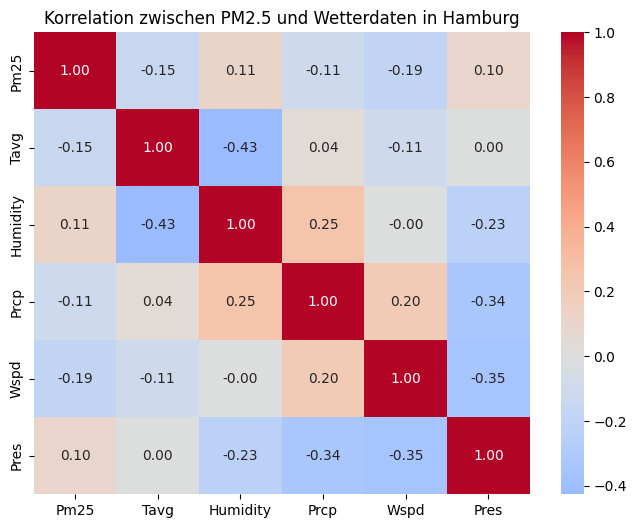

In [20]:
# Berechnung der Korrelationsmatrix
correlation_matrix = df_hamburg_pm25[['Pm25', 'Tavg', 'Humidity', 'Prcp', 'Wspd', 'Pres']].corr()

# Visualisierung der Korrelationsmatrix mit 'center=0'
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Korrelation zwischen PM2.5 und Wetterdaten in Hamburg')

Eine starke Korrelation zwischen dem Feinstaubwert und einer Wettervariablen ist nicht unmittelbar offensichtlich. Am stärksten ist mit -0,19 die Korrelation mit der Windgeschwindigkeit. Das bedeutet, dass in Zeiten mit wenig Wind die PM2.5-Werte tendenziell höher sind. Dies ist zu erwarten, da Wind dazu beiträgt, Luftschadstoffe zu vertreiben, während ruhiges Wetter (wenig Wind) zu einer Ansammlung von Schadstoffen führen kann.

Die Pearson-Korrelationsmatrix nimmt eine lineare Korrelation zwischen den Variablenpaaren an. Diese ist aber nicht zwingend gegeben (s. 2_eda_correlations.ipynb). Um zu sehen, wie die Korrelationen aussehen, erstellen wir Scatterplots:

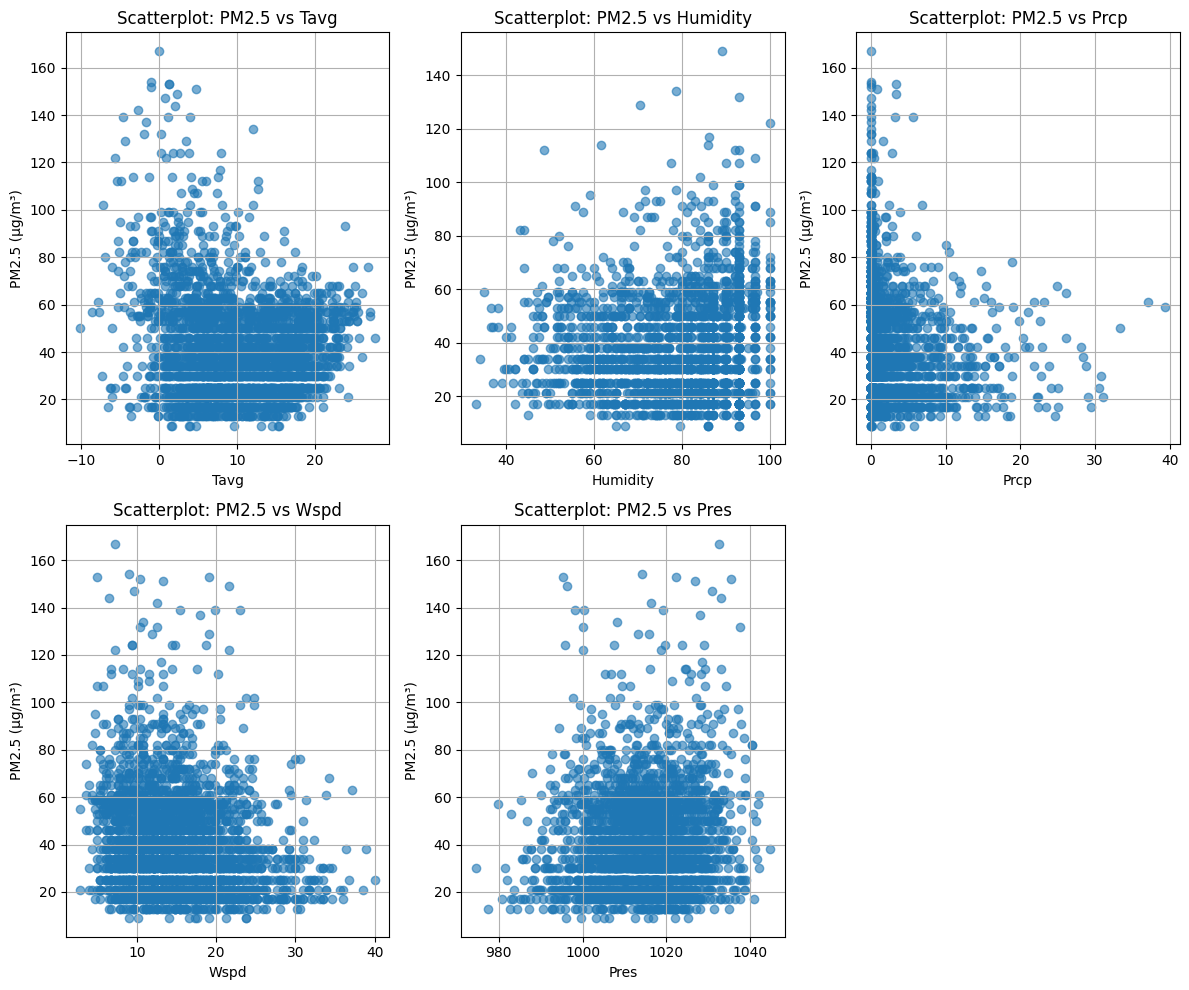

In [21]:
# Erstelle Scatterplots für jede Wettervariable im Vergleich zu PM2.5
variables = ['Tavg', 'Humidity', 'Prcp', 'Wspd', 'Pres']
plt.figure(figsize=(12, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # 2 Zeilen, 3 Spalten
    plt.scatter(df_hamburg_pm25[var], df_hamburg_pm25['Pm25'], alpha=0.6)
    plt.title(f'Scatterplot: PM2.5 vs {var}')
    plt.xlabel(var)
    plt.ylabel('PM2.5 (µg/m³)')
    plt.grid(True)

plt.tight_layout();

Nicht sicher, ob ich diesen Zweig hier weiterverfolgen möchte. Das Prinzip wird im Notebook zu Korrelationen ausführlich genug dargestellt.

# 2. Lineare Regression

Bevor wir ein Modell für lineare Regression verwenden können, müssen wir die NaN-Werte behandeln. Da wir Datumsangaben haben, könnten wir die Werte des Vortrags, bzw. der vorhergehenden Messung imputieren. Da der Datensatz aber mehrere längere Lücken aufweist, entscheiden wir uns für eine Imputation über den Median.

In [22]:
# Inputiere NaN-Werte mit dem Median der jeweiligen Spalte
df_hamburg_pm25.fillna(df_hamburg_pm25.median(), inplace=True)

# Überprüfung, ob NaN-Werte noch vorhanden sind
print(df_hamburg_pm25.isna().sum())

Year        0
Month       0
Day         0
Pm25        0
Tavg        0
Humidity    0
Prcp        0
Wspd        0
Pres        0
dtype: int64


/var/folders/9l/_gqvrbsd14zb0w_nlgtngd_w0000gn/T/ipykernel_5314/4149308259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hamburg_pm25.fillna(df_hamburg_pm25.median(), inplace=True)


Der Dataframe enthält nun keine NaN_Werte mehr und kann für die Modellierung verwendet werden.

### Lineare Regression mit Scikit-Learn und Statsmodels

Es soll ein lineares Regressionsmodell erstellt werden, um den Zusammenhang zwischen der Feinstaubbelastung (PM2.5) und verschiedenen Wetterfaktoren zu untersuchen.

Dabei werden zwei Bibliotheken kombiniert:

- **Scikit-Learn**: zum Trainieren des Modells und zur Berechnung des Bestimmtheitsmaßes $r^2$
- **Statsmodels**: zur detaillierten Analyse des Modells (Koeffizienten, Standardfehler, p-Werte, Konfidenzintervalle, usw.)

Die verwendeten unabhängigen Variablen (Features) sind:

- Durchschnittstemperatur (`Tavg`)
- Luftfeuchtigkeit (`Humidity`)
- Niederschlag (`Prcp`)
- Windgeschwindigkeit (`Wspd`)
- Luftdruck (`Pres`)

Die abhängige Variable ist die Feinstaubkonzentration (`Pm25`).


In [30]:
# Feature-Auswahl & Zielvariable definieren
features = ['Tavg', 'Humidity', 'Prcp', 'Wspd', 'Pres']
X = df_hamburg_pm25[features]
y = df_hamburg_pm25['Pm25']

In [31]:
# Scikit-Learn: Modelltraining
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X, y)

# Modellparameter anzeigen
print("Intercept (β₀):", lr_model.intercept_)
print("Koeffizienten (β₁...βₙ):", lr_model.coef_)
print("R² (Bestimmtheitsmaß):", lr_model.score(X, y))

Intercept (β₀): 6.95303340627332
Koeffizienten (β₁...βₙ): [-0.45161356  0.13475513 -0.40864833 -0.6645314   0.03882789]
R² (Bestimmtheitsmaß): 0.07180661894760054


In [32]:
# Statsmodels: Regressionsanalyse mit Zusammenfassung
X_sm = sm.add_constant(X)  # Intercept hinzufügen
ols_model = sm.OLS(y, X_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Pm25   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     43.76
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           1.36e-43
Time:                        19:56:16   Log-Likelihood:                -12634.
No. Observations:                2834   AIC:                         2.528e+04
Df Residuals:                    2828   BIC:                         2.532e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9530     45.808      0.152      0.8

### 📊 Interpretation der Regressionsanalyse

Die lineare Regressionsanalyse wurde durchgeführt, um den Einfluss verschiedener Wetterfaktoren auf die PM2.5-Konzentration in Hamburg zu untersuchen. Die Ergebnisse zeigen Folgendes:

#### 🔹 Modellgüte

- **r^2 = 0,072**: Nur etwa **7,2 %** der Varianz der PM2.5-Werte kann durch die gewählten Wettervariablen erklärt werden. Das Modell hat also eine geringe Vorhersagekraft.
- **Adj. r^2 = 0,070**: Auch die bereinigte Variante (angepasst an die Anzahl der Prädiktoren) bestätigt die geringe Erklärungskraft.
- **F-Statistik = 43.76**, **p < 0.001**: Das Modell als Ganzes ist dennoch **statistisch signifikant**, d. h. mindestens einer der Prädiktoren trägt systematisch zur Erklärung von PM2.5 bei.

#### 🔹 Koeffizienten und Signifikanz

| Variable   | Einflussrichtung | p-Wert  | Interpretation |
|------------|------------------|---------|----------------|
| **Tavg**   | negativ          | 0.000   | Höhere Temperaturen gehen mit niedrigeren PM2.5-Werten einher. |
| **Humidity** | positiv        | 0.000   | Höhere Luftfeuchtigkeit ist mit leicht erhöhten PM2.5-Werten assoziiert. |
| **Prcp**   | negativ          | 0.000   | Niederschlag reduziert die PM2.5-Konzentration – vermutlich durch Auswaschungseffekte. |
| **Wspd**   | negativ          | 0.000   | Höhere Windgeschwindigkeit führt zu einer Verdünnung von Feinstaub. |
| **Pres**   | kein signifikanter Effekt | 0.378 | Luftdruck scheint keinen nennenswerten Einfluss auf PM2.5 zu haben. |

Alle Wettervariablen außer dem Luftdruck zeigen einen **statistisch signifikanten Einfluss** auf die Feinstaubbelastung (p < 0.05).

#### 🧭 Fazit

Auch wenn das Modell nur einen kleinen Teil der Variation erklären kann, lassen sich einige **systematische Zusammenhänge** zwischen Wetterbedingungen und PM2.5-Konzentration erkennen. Diese Ergebnisse könnten ein nützlicher Ausgangspunkt für eine weiterführende Modellierung (z. B. mit nichtlinearen oder multivariaten Ansätzen) sein.
